Este fichero crea un dataset único con los datos de todas las compañias y realiza una predicción de todas sobre ese dataset.

In [23]:
# LIBRERIAS

import os
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt


#Comprobar que Tensorflow reconoce la tarjeta gráfica del equipo
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
# Lectura de ficheros con los datasets de las empresas a analizar
companies = {}
ficheros = os.listdir('data')

for file in ficheros:
    company = file[:-4]
    dfcompany = pd.read_csv(f"data/{file}")
    companies[company] = dfcompany


In [25]:
# Comprobación que de todas las empresas se dispone de al menos 1000 días de datos
for company in companies:
    dfcompany = companies[company]
    if dfcompany.shape[0] < 1000:
        print(company)

In [26]:
# Creación de una matriz de datos de para la red neuronal
def create_dataset(dataset, look_back):
	x_data, y_data = [], []
	for i in range(len(dataset)-look_back-1):
		x = dataset[i:(i+look_back), 0]
		x_data.append(x)
		y = dataset[i + look_back, 0]
		y_data.append(y)
        
	return np.array(x_data), np.array(y_data)

def graficar(dfcompany, company):
	plt.plot(dfcompany)
	plt.xlabel('Days')
	plt.ylabel('Price')
	plt.title(label=company)

# Graficar el resultado
def graficarResultado(dfcompany, company, look_back, train_predict, test_predict):
    # Ajustamos los datos para mostrar la predicción
    trainPredictPlot = np.empty_like(dfcompany)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict
    
    testPredictPlot = np.empty_like(dfcompany)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(dfcompany)-1, :] = test_predict

    # Mostrar las los datos originales y la predicción
    plt.plot(scaler.inverse_transform(dfcompany), label='Original data')
    plt.plot(trainPredictPlot, label='Train prediction')
    plt.plot(testPredictPlot, label='Test prediction')
    plt.legend()

    plt.title(f'Predicción con modelo 2 para {company}')
    
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()
	
#Separar datos de entrenamiento y test
def split (dfcompany, look_back, percent=70):
    training_size = int(len(dfcompany)*percent) 
    test_size = len(dfcompany)-training_size 

    train_data, test_data = dfcompany[0:training_size,:], dfcompany[training_size:len(dfcompany),:1]


    #Creamos la matriz para los datos de entrenamiento y test    
    X_train, y_train = create_dataset(train_data, look_back) 
    X_test, y_test = create_dataset(test_data, look_back) 
    #print(f"La matriz X_train tiene la forma: {X_train.shape}")
    #print(f"La matriz y_train tiene la forma: {y_train.shape}")
    #print(f"La matriz X_test tiene la forma: {X_test.shape}")
    #print(f"La matriz y_test tiene la forma: {y_test.shape}")
    

    # Hay que hacer reshape a las entradas de la red LSTM añadiendo 1 dimension [samples, look_back, features]
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)


    return X_train, X_test, y_train, y_test

In [27]:
def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()

  # Tune the number of units in the first LSTM layer
  # Choose an optimal value between 10-100
  hp_units0 = hp.Int('units0', min_value=10, max_value=100, step=20)
  model.add(LSTM(units=hp_units0, input_shape=(look_back,1), name='LSTM1'))

  
  # Add next layers
  model.add(keras.layers.Dropout(0.2))
  model.add(Dense(1, activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=['mse'])

  return model

In [28]:
def prediccion (model, scaler, X_train, X_test, y_train, y_test, look_back):
    # Realizar predicción sobre datos de entranamiento y test
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Transformamos los datos a su escala original
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    return  train_predict, test_predict

    
def generarHipermodelo(X_train, y_train, X_test, y_test): 
    # Perform hypertuning
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test,y_test), callbacks=[stop_early]) 

    best_hp = tuner.get_best_hyperparameters()[0]

    # Build the model with the optimal hyperparameters
    h_model = tuner.hypermodel.build(best_hp)
    h_model.summary()
    print(tuner.get_best_hyperparameters()[0].get('learning_rate'))

    print('#### Fin de optimizacion ####')

    return h_model

def generarResultadosAllCompanies(X_train, y_train, X_test, y_test):
    h_model = generarHipermodelo(X_train, y_train, X_test, y_test)
    #Entrenamiento del modelo mejorado
    history = h_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[stop_early])

    train_predict, test_predict = prediccion(h_model, scaler, X_train, X_test, y_train, y_test, look_back)

    # Calculamos el error en entrenamiento y test
    train_error = math.sqrt(mean_squared_error(y_train, train_predict))
    test_error = math.sqrt(mean_squared_error(y_test, test_predict))

    
    print(f"Error entrenamiento: {train_error}")
    print(f"Error test: {test_error}")

    #graficarResultado(dfcompany, look_back, train_predict, test_predict)
    return history, h_model, train_error, test_error, test_predict

In [29]:
# Instanciamos el tuner que optimizará los hiperparámetros del modelo
tuner = kt.Hyperband(model_builder, # the hypermodel
                    objective='val_loss', # objective to optimize
                    max_epochs=10,
                    factor=3, # the denominator of the number of models trained in every iteration of the training loop.
                    directory='keras_tuner_dir', # directory to save logs 
                    project_name='Stock_prediction')

# hypertuning settings
tuner.search_space_summary() 

# Stop Early para detener el entrenamiento y evitar overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=10, min_delta=0.5)

INFO:tensorflow:Reloading Oracle from existing project keras_tuner_dir\Stock_prediction\oracle.json
INFO:tensorflow:Reloading Tuner from keras_tuner_dir\Stock_prediction\tuner0.json
Search space summary
Default search space size: 3
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 20, 'sampling': None}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 20, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [30]:
# Definimos cuantos días usará el modelo para predecir el día siguiente
look_back = 50
scaler = StandardScaler()

# Concatenar X_train, X_test, y_train, y_test generados para cada empresa creando asi un cjto de entrenamiento y test con todos los datos disponibles
# La primera compañia del diccionario la generamos para poder hacer la concatenacion
# Obtenemos la primera compañia del diccionario 'companies' 
firstCompany = next(iter(companies))


dfcompany = companies[firstCompany]
dfcompany = dfcompany.reset_index()['close']
dfcompany = scaler.fit_transform(np.array(dfcompany).reshape(-1,1))
X_train, X_test, y_train, y_test = split(dfcompany, look_back, percent=0.90)


for company in companies:
    #print(np.shape(companies[company])[0])
    #La primera empresa la hemos añadido manualmente para que no haya errores al concatenar la primera vez
    if company != firstCompany:
        dfcompany = companies[company]
        dfcompany = dfcompany.reset_index()['close']
        dfcompany = scaler.fit_transform(np.array(dfcompany).reshape(-1,1))
        X_train2, X_test2, y_train2, y_test2 = split(dfcompany, look_back, percent=0.90)
        X_train = np.concatenate([X_train, X_train2])
        y_train = np.concatenate([y_train, y_train2])
        X_test = np.concatenate([X_test, X_test2])
        y_test = np.concatenate([y_test, y_test2])
    
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_test: {y_test.shape}")

Tamaño de X_train: (95849, 50, 1)
Tamaño de y_train: (95849,)
Tamaño de X_test: (6626, 50, 1)
Tamaño de y_test: (6626,)


In [31]:

history, h_model, train_error, test_error, test_predict = generarResultadosAllCompanies(X_train, y_train, X_test, y_test)
    


INFO:tensorflow:Oracle triggered exit
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 90)                33120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 90)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 91        
Total params: 33,211
Trainable params: 33,211
Non-trainable params: 0
_________________________________________________________________
0.01
#### Fin de optimizacion ####
Epoch 1/50
1199/1199 [==============================] - 14s 9ms/step - loss: 0.0217 - mse: 0.0217 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 2/50
1199/1199 [==============================] - 10s 8ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 3/50
1199/1199 [===============

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])
[0.01409728080034256, 0.013184783980250359, 0.012847663834691048, 0.013438970781862736, 0.013564430177211761, 0.0132954316213727, 0.012981327250599861, 0.013363569043576717, 0.012755104340612888, 0.012965669855475426, 0.012982005253434181]


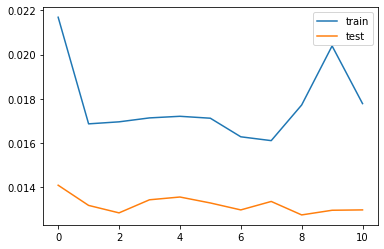

In [32]:
print(history.history.keys())

print(history.history['val_loss'])

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

plt.show()

Prueba de error en algunas predicciones:

In [33]:
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

In [34]:

index = 1
#value_at_index = list(companies.values())[index]
#print(value_at_index)

print(np.shape(y_test))
print(f"Valor real: {y_test[index]}")
print(f"Valor predicción: {test_predict[index]}")


(6626, 1)
Valor real: [45.27547385]
Valor predicción: [44.926212]


Error entrenamiento: 176.06480518727903
Error test: 283.5783893080524


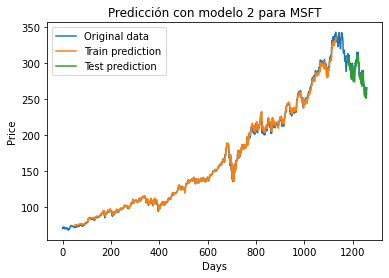

In [35]:
company = 'MSFT'
dfcompany = companies[company]
dfcompany = dfcompany.reset_index()['close']
dfcompany = scaler.fit_transform(np.array(dfcompany).reshape(-1,1))
X_train, X_test, y_train, y_test = split(dfcompany, look_back, percent=0.90)

train_predict, test_predict = prediccion(h_model, scaler, X_train, X_test, y_train, y_test, look_back)

# Calculamos el error en entrenamiento y test
train_error_company = math.sqrt(mean_squared_error(y_train, train_predict))
test_error_company = math.sqrt(mean_squared_error(y_test, test_predict))


print(f"Error entrenamiento: {train_error_company}")
print(f"Error test: {test_error_company}")
graficarResultado(dfcompany, company, look_back, train_predict, test_predict)
